<a href="https://colab.research.google.com/github/seongyunlee/Water-Pipe-Leakage-Recognition/blob/main/test_voice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import IPython.display as ipd
import matplotlib
import numpy as np
import tensorflow as tf
import librosa
import urllib
import pylab
import cv2
import librosa.display
import math

In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def make_chromagram(sound_signal):
    stft_result = librosa.stft(sound_signal, n_fft=512,hop_length=512)
    D = np.abs(stft_result)
    S_dB = librosa.amplitude_to_db(D, ref=np.max)
    return S_dB, sound_signal

In [ ]:
def chroma(sound):
    chromagram , sound_signal = make_chromagram(sound)
    chromagram = cv2.cvtColor(chromagram, cv2.COLOR_GRAY2BGR)
    chromagram = tf.keras.preprocessing.image.array_to_img(chromagram)
    chromagram = np.array(chromagram)
    return chromagram



In [ ]:
def make_mel(sound_signal):
    mel_result = librosa.feature.melspectrogram(y=sound_signal, sr=22050, n_mels=224,fmax=8000)
    D = np.abs(mel_result)
    S_dB = librosa.amplitude_to_db(D, ref=np.max)
    return S_dB, sound_signal

In [ ]:
def mel(sound):
    mel_spec , sound_signal = make_mel(sound)
    mel_spec = cv2.cvtColor(mel_spec, cv2.COLOR_GRAY2BGR)
    mel_spec = tf.keras.preprocessing.image.array_to_img(mel_spec)
    mel_spec = np.array(mel_spec)
    return mel_spec

In [ ]:
def make_mfcc(sound_signal):
    mfcc_result = librosa.feature.mfcc(y=sound_signal, n_mfcc=32,sr=22050)
    D = np.abs(mfcc_result)
    S_dB = librosa.power_to_db(D, ref=np.max)
    return S_dB, sound_signal

In [ ]:
def mfcc(sound):
    mfcc , sound_signal = make_mfcc(sound)
    mfcc = cv2.cvtColor(mfcc, cv2.COLOR_GRAY2BGR)
    mfcc = tf.keras.preprocessing.image.array_to_img(mfcc)
    mfcc = np.array(mfcc)
    return mfcc

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from keras.models import Model, Sequential
from keras.layers import *
from keras.initializers import glorot_uniform
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import DenseNet121

from sklearn.svm import SVC



def get_model(train):

    inputs = Input(shape=train[0].shape)
    efficientnet_layers = DenseNet121(weights='imagenet', include_top=False, input_shape = train[0].shape, pooling='avg')
    model_output = efficientnet_layers.layers[-1].output
    for layer in efficientnet_layers.layers[:300]:
         layer.trainable = False
    outputs = Dense(200, activation = 'softmax')(model_output)
    model = Model(efficientnet_layers.input, outputs)

    return model

def train_and_test(x_train,y_train,x_test,y_test):
  x_train = np.expand_dims(x_train, axis=2)
  x_test = np.expand_dims(x_test, axis=2)

  model = Sequential()



  # Add a 1D convolutional layer
  model.add(Conv1D(filters=32, kernel_size=10, activation='relu', input_shape=x_train[0].shape))

  # Add max pooling layer
  model.add(MaxPooling1D(pool_size=2))

  # Flatten the output
  model.add(Flatten())

  # Add a dense layer for binary classification
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Train the model
  model.fit(x_train, y_train, batch_size=32, epochs=150, validation_data=(x_test, y_test))

  # Evaluate the model
  loss, accuracy = model.evaluate(x_test, y_test)
  print(f'Test loss: {loss:.4f}')
  print(f'Test accuracy: {accuracy:.4f}')

# 구글 드라이브에서 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

normal = list(glob.glob('/content/drive/MyDrive/train/normal/*.wav'))
leak = list(glob.glob('/content/drive/MyDrive/train/leak/*.wav'))

Mounted at /content/drive


# 데이터 전처리



In [ ]:
sound_length=110308 # 110308 samples
def tile_sound(file_name):
  sound_signal, sr = librosa.load(file_name,sr=22050)
  sound_signal = sound_signal[11025:]
  if len(sound_signal)<sound_length:
    sound_signal = np.tile(sound_signal,math.ceil(sound_length/len(sound_signal)))
  if len(sound_signal)>sound_length:
    sound_signal = sound_signal[:sound_length]
  return sound_signal

In [ ]:
preprocess_method = chroma

length = 1000

sound_leak = [preprocess_method(tile_sound(file_name)) for file_name in leak[:length]]
sound_normal = [preprocess_method(tile_sound(file_name)) for file_name in normal[:len(sound_leak)]]

n_normal=len(sound_leak)
n_leak=len(sound_normal)


print('정상데이터:',n_normal,'누수 데이터:',n_leak)

combine = sound_normal + sound_leak



label = [1]*n_normal + [0]*n_leak

정상데이터: 1000 누수 데이터: 1000


#학습/테스트 데이터 분리

Kfold 5개 세트로 분리


shape: (257, 216, 3)


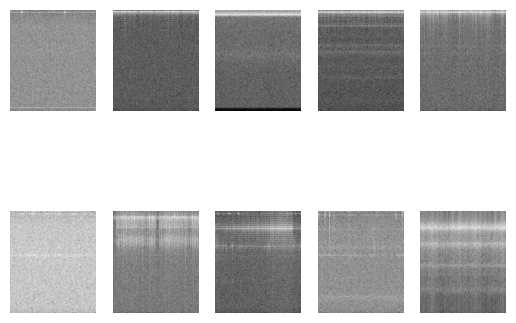

In [ ]:
print("shape:",combine[2].shape)

samples = sound_leak[:5] + sound_normal[:5]
fig, axes = plt.subplots(2, 5)

# 각 서브플롯에 배열 표시
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i])
    ax.axis('off')  # 축 제거 (선택적)

plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

folds = list(skf.split(combine, label))

  # 학습 및 테스트

In [ ]:
for i, (train_index, test_index) in enumerate(folds):
  print('fold:',str(i))
  train = np.array([combine[i] for i in train_index])
  test = np.array([combine[i] for i in test_index])
  train_label = [label[i] for i in train_index]
  test_label = [label[i] for i in test_index]
  print('학습 정상 데이터:',train_label.count(1),'비정상 데이터:',train_label.count(0))
  print('테스트 데이터:',test_label.count(1),'비정상 데이터:',test_label.count(0))
  result = train_and_test(train,test,train_label,test_label)
  print(result)


fold: 0
학습 정상 데이터: 800 비정상 데이터: 800
테스트 데이터: 200 비정상 데이터: 200
13/13 [==============================] - 83s 6s/step
(0.69, 0.7289156626506024, 0.6623931623931624)
fold: 1
학습 정상 데이터: 800 비정상 데이터: 800
테스트 데이터: 200 비정상 데이터: 200
13/13 [==============================] - 84s 6s/step
(0.6575, 0.6363636363636364, 0.6863905325443787)
fold: 2
학습 정상 데이터: 800 비정상 데이터: 800
테스트 데이터: 200 비정상 데이터: 200
13/13 [==============================] - 79s 6s/step
(0.6875, 0.6829268292682927, 0.6923076923076923)
fold: 3
학습 정상 데이터: 800 비정상 데이터: 800
테스트 데이터: 200 비정상 데이터: 200
13/13 [==============================] - 76s 6s/step
(0.7175, 0.7208121827411168, 0.7142857142857143)
fold: 4
학습 정상 데이터: 800 비정상 데이터: 800
테스트 데이터: 200 비정상 데이터: 200
13/13 [==============================] - 77s 6s/step
(0.7225, 0.7572254335260116, 0.6960352422907489)
